For demo, see the throw.ipynb

Autoformer

In [16]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [17]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, df, context_length, prediction_length, lags_sequence):
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.lags_sequence = lags_sequence
        self.max_lag = max(lags_sequence)
        self.required_past_length = context_length + self.max_lag

        self.values = df['requests'].values
        self.features = df[['memory', 'cpu']].values

        self.length = len(df) - self.required_past_length - prediction_length + 1

        self.static_real = np.array([df['cpu'].mean(), df['memory'].mean()])
        self.static_cat = np.array([0])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        past_values = self.values[idx : idx + self.required_past_length]
        past_time_features = self.features[idx : idx + self.required_past_length]

        future_values = self.values[
            idx + self.required_past_length : idx + self.required_past_length + self.prediction_length
        ]
        future_time_features = self.features[
            idx + self.required_past_length : idx + self.required_past_length + self.prediction_length
        ]

        past_observed_mask = ~np.isnan(past_values)
        future_observed_mask = ~np.isnan(future_values)

        return {
            'past_values': torch.tensor(past_values, dtype=torch.float),
            'past_time_features': torch.tensor(past_time_features, dtype=torch.float),
            'past_observed_mask': torch.tensor(past_observed_mask, dtype=torch.float),
            'future_values': torch.tensor(future_values, dtype=torch.float),
            'future_time_features': torch.tensor(future_time_features, dtype=torch.float),
            'future_observed_mask': torch.tensor(future_observed_mask, dtype=torch.float),
            'static_real_features': torch.tensor(self.static_real, dtype=torch.float),
            'static_categorical_features': torch.tensor(self.static_cat, dtype=torch.long),
        }


In [18]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

In [19]:
lags_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # can include 0 if needed
context_len = 11  # 21 - max(lags_seq)
prediction_len = 1


In [20]:
dataset = TimeSeriesWindowDataset(df, context_length=context_len, prediction_length=prediction_len, lags_sequence=lags_seq)

In [21]:
loader = DataLoader(dataset, batch_size=144, shuffle=True)
for batch in loader:
    print("past values:", batch['past_values'].shape, end="\n")  
    print("past_time_features: ",batch['past_time_features'].shape, end="\n") 
    print("past_observed_mask: ",batch['past_observed_mask'].shape, end="\n")
    print("future_values: ",batch['future_values'].shape, end="\n") 
    print("future_time_series: ",batch['future_time_features'].shape, end="\n") 
    print("future_observed_mask: ",batch['future_observed_mask'].shape, end="\n") 
    break


past values: torch.Size([144, 21])
past_time_features:  torch.Size([144, 21, 2])
past_observed_mask:  torch.Size([144, 21])
future_values:  torch.Size([144, 1])
future_time_series:  torch.Size([144, 1, 2])
future_observed_mask:  torch.Size([144, 1])


MODEL CONFIGURATION

In [22]:
from transformers import AutoformerForPrediction, AutoformerConfig
config = AutoformerConfig(
    context_length=context_len,
    prediction_length=prediction_len,
    lags_sequence=lags_seq,
    input_size=1,
    num_time_features=2,
    static_categorical_cardinalities=[1],
    static_real_features=2,
)

model = AutoformerForPrediction(config)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50  #

Training Part

In [25]:
model.train()
for epoch in range(10):
    total_loss = 0
    for batch in loader:
        # Move batch tensors to the same device as model
        batch = {k: v.to(device) for k, v in batch.items()}

        output = model(
            past_values=batch['past_values'],
            past_time_features=batch['past_time_features'],
            past_observed_mask=batch['past_observed_mask'],
            future_values=batch['future_values'],
            future_time_features=batch['future_time_features'],
            # static_real_features=batch['static_real_features'],
            # static_categorical_features=batch['static_categorical_features']
        )

        loss = output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 1/50, Loss: 264.1052
Epoch 2/50, Loss: 240.5143
Epoch 3/50, Loss: 240.8292
Epoch 4/50, Loss: 236.9839
Epoch 5/50, Loss: 237.4798
Epoch 6/50, Loss: 235.1051
Epoch 7/50, Loss: 234.8976
Epoch 8/50, Loss: 237.1533
Epoch 9/50, Loss: 232.5583
Epoch 10/50, Loss: 232.6303


Evaluation Part

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


def evaluate_forecast(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'MSE': round(mse, 4),
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'R2': round(r2, 4)
    }

Evaluation on entire dataset

In [27]:
model.eval()
all_y_true = []
all_y_pred = []

with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model.generate(
            past_values=batch['past_values'],
            past_time_features=batch['past_time_features'],
            past_observed_mask=batch['past_observed_mask'],
            future_time_features=batch['future_time_features'],
        )

        normalized_forecast = outputs.sequences

        loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)
        scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)
        scale[scale == 0] = 1.0

        rescaled_forecast = normalized_forecast * scale + loc
        first_pred = rescaled_forecast[:, 0, :]  # First-step forecast

        all_y_true.append(batch['future_values'].cpu().numpy())
        all_y_pred.append(first_pred.cpu().numpy())

# Flatten all results
y_true = np.concatenate(all_y_true).flatten()
y_pred = np.concatenate(all_y_pred).flatten()

# Evaluate
metrics = evaluate_forecast(y_true, y_pred)
print("Evaluation Metrics (Autoformer Model):", metrics)


Evaluation Metrics (Autoformer Model): {'MSE': 16102066176.0, 'RMSE': 126893.917, 'MAE': 16105.6328, 'R2': -246825.0}


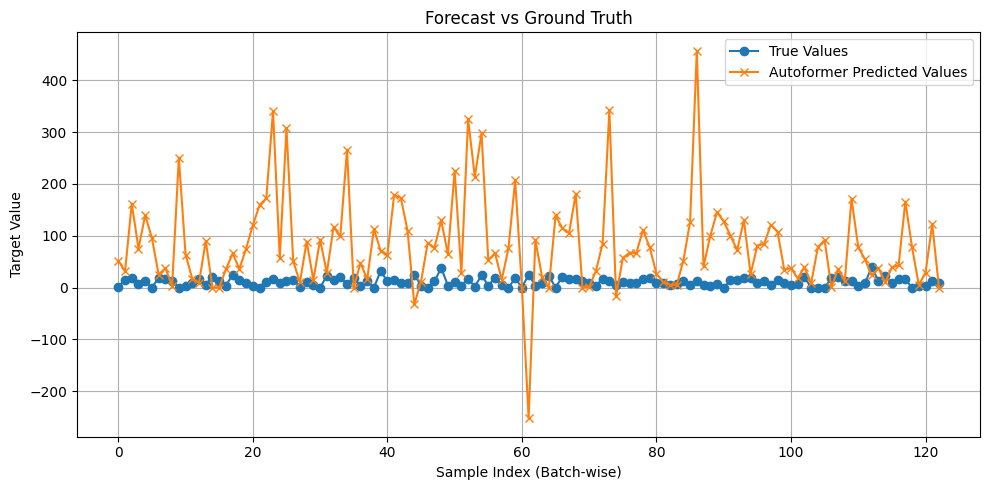

In [ ]:
import matplotlib.pyplot as plt

# #single batch plotting
# y_true = true_values.cpu().numpy().flatten()
# y_pred = first_pred.cpu().numpy().flatten()

# entire dataset
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="True Values", marker='o')
plt.plot(y_pred, label="Autoformer Predicted Values", marker='x')
plt.title("Forecast vs Ground Truth")
plt.xlabel("Sample Index (Batch-wise)")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluation on a single batch

In [ ]:
# model.eval()

# # Grab a batch
# for batch in loader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     break

# # Generate predictions
# with torch.no_grad():
#     outputs = model.generate(
#         past_values=batch['past_values'],
#         past_time_features=batch['past_time_features'],
#         past_observed_mask=batch['past_observed_mask'],
#         future_time_features=batch['future_time_features'],
#         # static_real_features=batch['static_real_features'],  # if you're using these
#         # static_categorical_features=batch['static_categorical_features'],
#     )

# normalized_forecast = outputs.sequences  

# loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)   # [B, 1, 1]
# scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)  # [B, 1, 1]

# scale[scale == 0] = 1.0

# rescaled_forecast = normalized_forecast * scale + loc

# first_pred = rescaled_forecast[:, 0, :]  # [batch_size, 1]
# true_values = batch['future_values']


# true_values.cpu()
# first_pred.cpu()
# # print("Ground truth:\n", true_values)
# print(evaluate_forecast(true_values.cpu().numpy(), first_pred.cpu().numpy()))

##### INITIAL MODEL CONFIGURATION

In [ ]:
outputs.sequences

tensor([[[  6.0569],
         [  5.8163],
         [  7.6062],
         ...,
         [ 11.5266],
         [  8.0976],
         [  7.1649]],

        [[  9.4233],
         [ 48.7327],
         [ 16.2829],
         ...,
         [ 17.3463],
         [  9.9242],
         [ 42.7272]],

        [[ 20.0895],
         [ 11.0148],
         [ 10.4588],
         ...,
         [ 11.4782],
         [ 16.0869],
         [ 12.0073]],

        ...,

        [[ 16.8729],
         [ 27.7739],
         [ 11.7631],
         ...,
         [ 12.4306],
         [ 12.0959],
         [  7.2118]],

        [[  6.6443],
         [  4.7968],
         [ 16.2218],
         ...,
         [ 16.8308],
         [ 12.5499],
         [ 39.6559]],

        [[  8.1527],
         [ 21.0221],
         [ 21.5583],
         ...,
         [ 14.7390],
         [  5.4571],
         [-10.8339]]], device='cuda:0')

In [ ]:
# Unsqueeze loc and scale for broadcasting
loc = output.loc.unsqueeze(1)      # [10, 1] -> [10, 1, 1]
scale = output.scale.unsqueeze(1)  # [10, 1] -> [10, 1, 1]

# Decode
normalized_forecast = outputs.sequences
rescaled_forecast = normalized_forecast * scale + loc

print("Rescaled forecast shape:", normalized_forecast.shape)
print("Rescaled forecast:", rescaled_forecast.shape)


Rescaled forecast shape: torch.Size([123, 100, 1])
Rescaled forecast: torch.Size([123, 100, 1])


In [ ]:
outputs.sequences.shape

torch.Size([123, 100, 1])

In [ ]:
true_values = batch['future_values']
print("Ground truth:", true_values)
print("Prediction:", rescaled_forecast)


Ground truth: tensor([[ 2.],
        [15.],
        [19.],
        [ 7.],
        [12.],
        [ 0.],
        [19.],
        [16.],
        [13.],
        [ 0.],
        [ 4.],
        [ 9.],
        [16.],
        [ 6.],
        [21.],
        [12.],
        [ 4.],
        [25.],
        [15.],
        [ 8.],
        [ 4.],
        [ 0.],
        [10.],
        [16.],
        [ 8.],
        [13.],
        [15.],
        [ 2.],
        [10.],
        [ 6.],
        [ 0.],
        [23.],
        [15.],
        [20.],
        [ 7.],
        [18.],
        [ 4.],
        [13.],
        [ 0.],
        [32.],
        [12.],
        [14.],
        [ 8.],
        [ 8.],
        [25.],
        [ 4.],
        [ 0.],
        [12.],
        [38.],
        [ 4.],
        [10.],
        [ 4.],
        [17.],
        [ 2.],
        [24.],
        [ 4.],
        [19.],
        [ 6.],
        [ 0.],
        [18.],
        [ 0.],
        [25.],
        [ 4.],
        [ 8.],
        [23.],
        [ 0

In [ ]:
first_pred = rescaled_forecast[:, 0, :]  # shape: [10, 1]
true_values = batch['future_values']  # shape: [10, 1]
print("Ground truth:", true_values)
print("Prediction:", first_pred)

Ground truth: tensor([[ 2.],
        [15.],
        [19.],
        [ 7.],
        [12.],
        [ 0.],
        [19.],
        [16.],
        [13.],
        [ 0.],
        [ 4.],
        [ 9.],
        [16.],
        [ 6.],
        [21.],
        [12.],
        [ 4.],
        [25.],
        [15.],
        [ 8.],
        [ 4.],
        [ 0.],
        [10.],
        [16.],
        [ 8.],
        [13.],
        [15.],
        [ 2.],
        [10.],
        [ 6.],
        [ 0.],
        [23.],
        [15.],
        [20.],
        [ 7.],
        [18.],
        [ 4.],
        [13.],
        [ 0.],
        [32.],
        [12.],
        [14.],
        [ 8.],
        [ 8.],
        [25.],
        [ 4.],
        [ 0.],
        [12.],
        [38.],
        [ 4.],
        [10.],
        [ 4.],
        [17.],
        [ 2.],
        [24.],
        [ 4.],
        [19.],
        [ 6.],
        [ 0.],
        [18.],
        [ 0.],
        [25.],
        [ 4.],
        [ 8.],
        [23.],
        [ 0

In [ ]:
{'MSE': 13260.2734, 'RMSE': 115.1533, 'MAE': 78.879, 'R2': -235.7719}



import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))

test_target_pd = test_target.to_series()
pred_series_pd = nbeats_pred_series.to_series()

plt.plot(test_target_pd, label="Actual Requests", linewidth=2, color="black")

# Plot predicted data with better visibility
plt.plot(pred_series_pd, label="Predicted Requests", linestyle="dashed", linewidth=2.5, color="blue", alpha=0.8)

plt.title("Actual vs Predicted Requests")
plt.xlabel("Time")
plt.ylabel("Requests")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
({'MSE': 75.57113, 'RMSE': 8.693166, 'MAE': 6.751214, 'R2': -0.6134726},
 {'MSE': 74.742165, 'RMSE': 8.645355, 'MAE': 6.8097286, 'R2': -0.59577394})

In [ ]:
metMap = {
    'tcn': {
        'mse': 75.57113,
        'rmse': 8.693166,
        'mae': 6.751214,
        'r2': -0.6134726,
    },
    'autoformer': {
        'mse': 10378.6895,
        'rmse': 115.1533,
        'mae': 78.879,
        'r2': -235.7719,
    },
    'nbeats': {
        'mse': 74.742165,
        'rmse': 8.645355,
        'mae': 6.8097286,
        'r2': -0.59577394,
    },
    'arima': {
        'mse': 8.47,
        'rmse': 2.90,
        'mae': 4.751214,
        'r2': -0.6134726,
    },

}

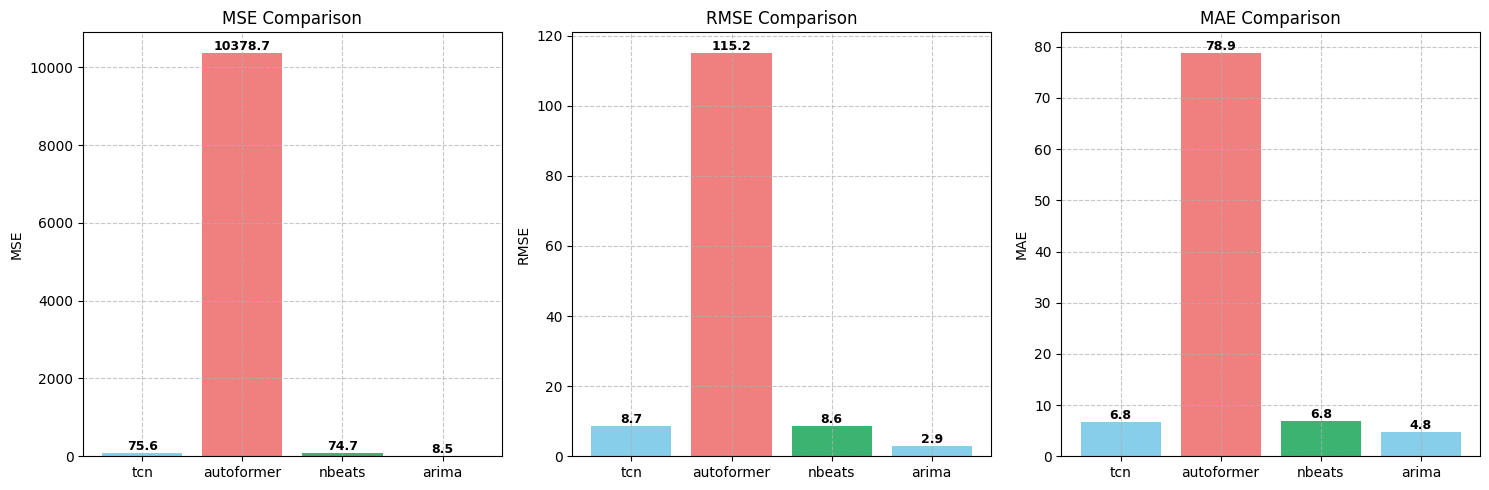

In [ ]:
import matplotlib.pyplot as plt

def plot_metric_comparison_colorful_annotated(metMap):
    models = list(metMap.keys())
    mse = [metMap[model]['mse'] for model in models]
    rmse = [metMap[model]['rmse'] for model in models]
    mae = [metMap[model]['mae'] for model in models]

    metrics = ['MSE', 'RMSE', 'MAE']
    values = [mse, rmse, mae]

    colors = ['skyblue', 'lightcoral', 'mediumseagreen']  # TCN, Autoformer, N-BEATS

    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        bars = plt.bar(models, values[i], color=colors)
        plt.title(f'{metric} Comparison')
        plt.ylabel(metric)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Annotate values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.1f}',
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

# Usage
plot_metric_comparison_colorful_annotated(metMap)
